In [6]:
# ANOTHER change 

import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
import h5py
from astropy.constants import G

import matplotlib
import matplotlib.pyplot as plt
import os
os.environ["PATH"] += os.pathsep + "/Library/TeX/texbin"
plt.style.use('my_standard.mplstyle')
import gala
from gala.coordinates import OrphanKoposov19, GD1Koposov10

galcen_v_sun = (11.1, 245, 7.3)*u.km/u.s
galcen_distance = 8.249*u.kpc

In [39]:
with h5py.File('stream-runs/stream_2.hdf5','r') as file:
    pos = np.array(file['positions'])
    vel = np.array(file['velocities'])
    start_times = np.array(file['times'])

In [41]:
leapfrog_final_xs, leapfrog_final_vs = pos[-1], vel[-1]

In [42]:
gc = SkyCoord(x=leapfrog_final_xs[:,0]*u.kpc, y=leapfrog_final_xs[:,1]*u.kpc, z=leapfrog_final_xs[:,2]*u.kpc,
                          v_x=leapfrog_final_vs[:,0]*u.km/u.s, v_y=leapfrog_final_vs[:,1]*u.km/u.s, v_z=leapfrog_final_vs[:,2]*u.km/u.s,
                          frame='galactocentric',  galcen_v_sun=galcen_v_sun, galcen_distance=galcen_distance)

gc_trans = gc.transform_to(GD1Koposov10)
gc_trans_rc = gala.coordinates.reflex_correct(gc_trans)

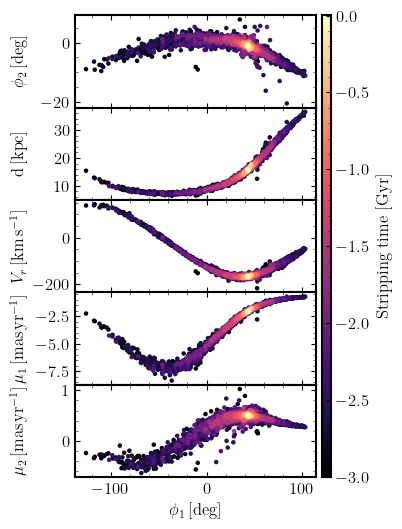

In [43]:
fig_observables, ax = plt.subplots(5,1, sharex='col', sharey='row', figsize=(3.75,6))

for i in range(5):
    ax[i].tick_params(labelsize=12)
plt.subplots_adjust(hspace=0, wspace=0.)
        
# phi1 vs phi2
plot= ax[0].scatter(gc_trans_rc.phi1, gc_trans_rc.phi2,s=5, c=start_times, rasterized=True)
ax[0].set_ylabel('$\phi_{2}\,[\mathrm{deg}]$')

# phi1 vs distance
ax[1].scatter(gc_trans_rc.phi1, gc_trans_rc.distance,s=5, c=start_times,  rasterized=True)
ax[1].set_ylabel('$\mathrm{d}\,[\mathrm{kpc}]$')

# phi1 vs Vr
ax[2].scatter(gc_trans_rc.phi1, gc_trans_rc.radial_velocity, s=5,c=start_times, rasterized=True)
ax[2].set_ylabel('$V_{r}\,[\mathrm{km}\,\mathrm{s}^{-1}]$')

# phi1 vs pm1
ax[3].scatter(gc_trans_rc.phi1, gc_trans_rc.pm_phi1_cosphi2,s=5, c=start_times, rasterized=True)
ax[3].set_ylabel('$\mu_{1}\,[\mathrm{mas}\,\mathrm{yr}^{-1}]$')

ax[4].scatter(gc_trans_rc.phi1, gc_trans_rc.pm_phi2, s=5,c=start_times, rasterized=True)
ax[4].set_xlabel('$\phi_{1}\,[\mathrm{deg}]$')
ax[4].set_ylabel('$\mu_{2}\,[\mathrm{mas}\,\mathrm{yr}^{-1}]$')


cb = fig_observables.colorbar(plot,  ax=ax, location='right', aspect=50, pad=0.02)
cb.set_label(r'Stripping time [Gyr]')
cb.ax.tick_params(labelsize=12)

fig_observables.align_labels()

# plt.savefig('Figures/meeting_081123/fig1-flhaloes')